### Diving down the gastrointestinal tract

Goal: Classify significant items in the gastrointestinal tract.

The Kvasir dataset contains 8,000 images, 8 classes, 1,000 images for each class of the gastrointestinal (GI) tract that have been verified by edical doctors (experienced endoscopists).


Classifies images from the Kvasir set
http://datasets.simula.no/kvasir/#data-collection

In [1]:
#Load Everything and ensure that during changes items are reloaded
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#import fastai.. cheat and load everything!
from fastai import *
#import fastai more specific
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
#path to the data
# using http://datasets.simula.no/kvasir/data/kvasir-dataset.zip
path = Path('/home/jd/data/kvasir-dataset-v2'); path.ls()

[PosixPath('/home/jd/data/kvasir-dataset-v2/test'),
 PosixPath('/home/jd/data/kvasir-dataset-v2/valid'),
 PosixPath('/home/jd/data/kvasir-dataset-v2/train'),
 PosixPath('/home/jd/data/kvasir-dataset-v2/models'),
 PosixPath('/home/jd/data/kvasir-dataset-v2/files.txt')]

I used a bash script to divide everything up similar to imagenet. Use at your own risk.
#!/bin/bash
ls > files
mkdir train valid test
while read p; do
	mkdir valid/$p 
	mv $p train/
	cd ~/data/kvasir-dataset-v2/train/$p
	mv `ls | head -100` ~/data/kvasir-dataset-v2/valid/$p
	cd ~/data/kvasir-dataset-v2/
done < files

In [4]:
# We are using batchsize of 64
bs = 64
# This is what we want to flip and move around; we want to do just basic stuff at first
tfms = get_transforms(do_flip=True)
# pulls and formats the data by looking for the
# path= where it is stored
# ds_tfms= the transforms we want of the images
# size= how big the images should be
# bs= batchsize that we can fit with the GPU Ram; Mine is 64 for 8gb
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=224, bs=bs)
# lists out the classes
data.classes

['dyed-lifted-polyps',
 'dyed-resection-margins',
 'esophagitis',
 'normal-cecum',
 'normal-pylorus',
 'normal-z-line',
 'polyps',
 'ulcerative-colitis']

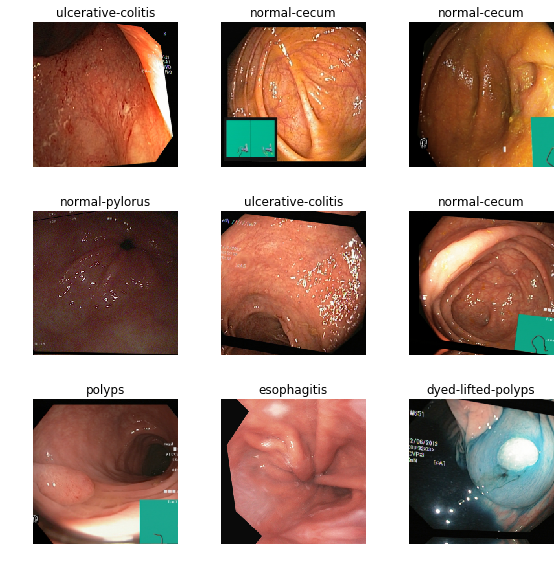

In [5]:
#show some of them with labels
data.show_batch(rows=3, figsize=(8,8))

In [6]:
# What are the 8 classes we are seeing
print(data.classes)

['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']


# Training: resnet34

Resnet34 has 34 layers of image finding goodness. I start with this one because it is faster and will figure out if data if formatted correctly.

In [7]:
# learn will be a convultional neural network (cnn) that takes in several items
# data = our images that have been setup
# architecture = is the model we are choosing. In this case Resnet34
# metrics = is how we are going to gauge success
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [8]:
# We are going to run this 4 times
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,0.785920,0.470256,0.165000
2,0.494887,0.382761,0.151250
3,0.383587,0.350683,0.136250
4,0.335502,0.350337,0.135000


In [9]:
# we save our results weights to use later
learn.save('Kvest-stage-1')

## Results

In [10]:
# This gathers the data together for the comparing top losses and confusion Matrix
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

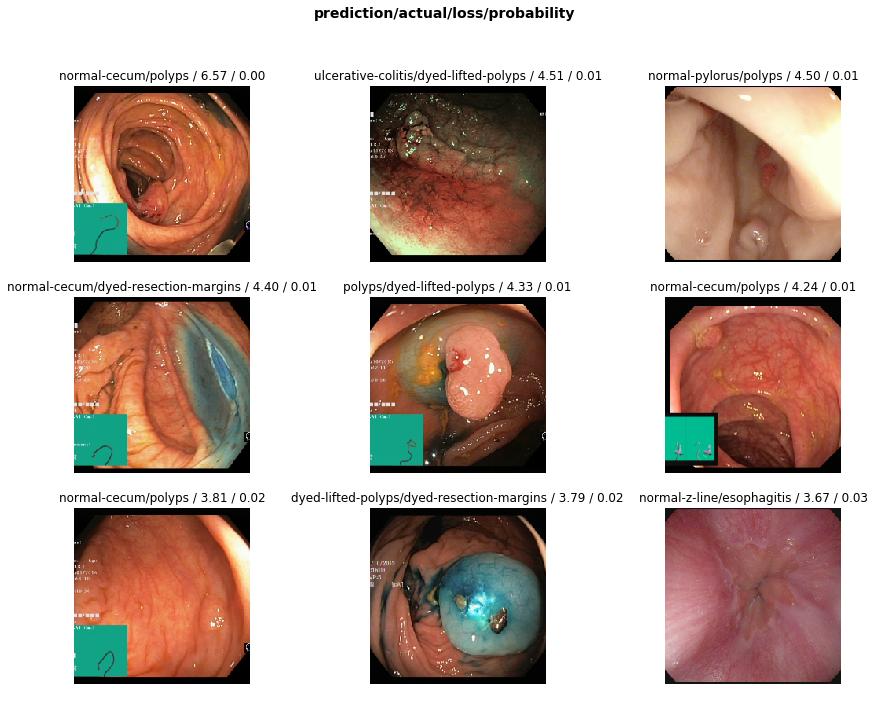

In [11]:
#Lists the top categories
interp.plot_top_losses(9, figsize=(15,11))

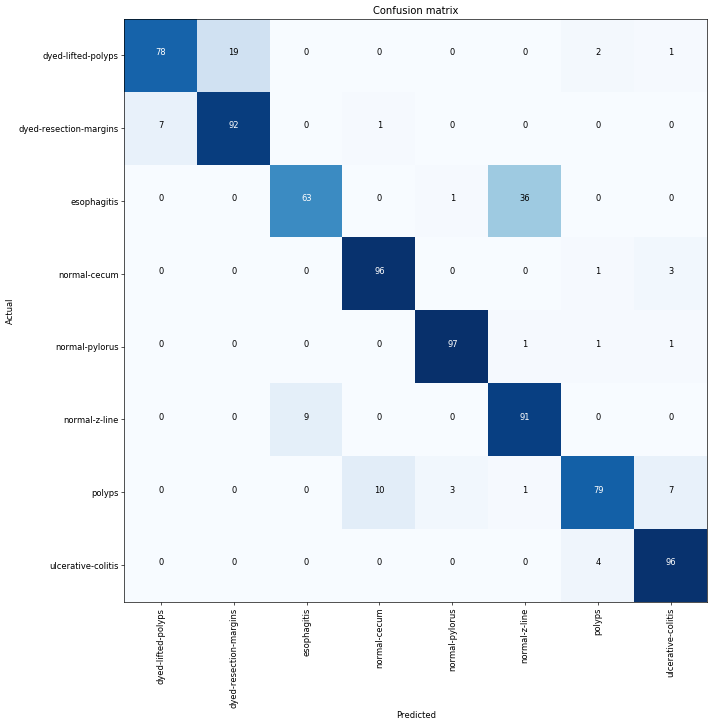

In [12]:
#shows where things went wrong in a confusion matrix
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [13]:
#most confused
interp.most_confused(min_val=2)

[('esophagitis', 'normal-z-line', 36),
 ('dyed-lifted-polyps', 'dyed-resection-margins', 19),
 ('polyps', 'normal-cecum', 10),
 ('normal-z-line', 'esophagitis', 9),
 ('dyed-resection-margins', 'dyed-lifted-polyps', 7),
 ('polyps', 'ulcerative-colitis', 7),
 ('ulcerative-colitis', 'polyps', 4),
 ('normal-cecum', 'ulcerative-colitis', 3),
 ('polyps', 'normal-pylorus', 3)]

## Unfreezing, fine-tuning, and learning rates

In [14]:
# We are going to fine tune the model.
# First we want to load the previous weights
learn.load('Kvest-stage-1');
# We are going to find the optimal learning rate curve
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


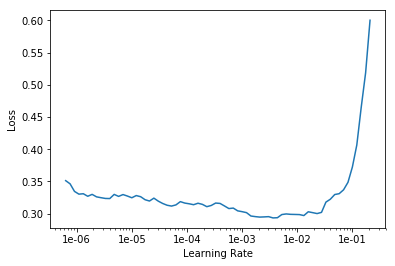

In [15]:
#shows the curve; we choose a point that is solidly low
learn.recorder.plot()

In [16]:
#we are going to unfreeze the model allowing the pretrained weights to move around a bit.
learn.unfreeze()
#we break this up. Lower layers change weights more slowly than higher layers. Run twice
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.305068,0.322448,0.130000
2,0.277249,0.316053,0.121250


In [17]:
#we break this up. Lower layers change weights more slowly than higher layers. Run twice
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.261229,0.303502,0.115000
2,0.237041,0.295384,0.108750


In [18]:
# Save our new findings
learn.save('Kvest-stage-2')

## Unfreezing and fine-tuning results

In [19]:
# This gathers the data together for the comparing top losses and confusion Matrix
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

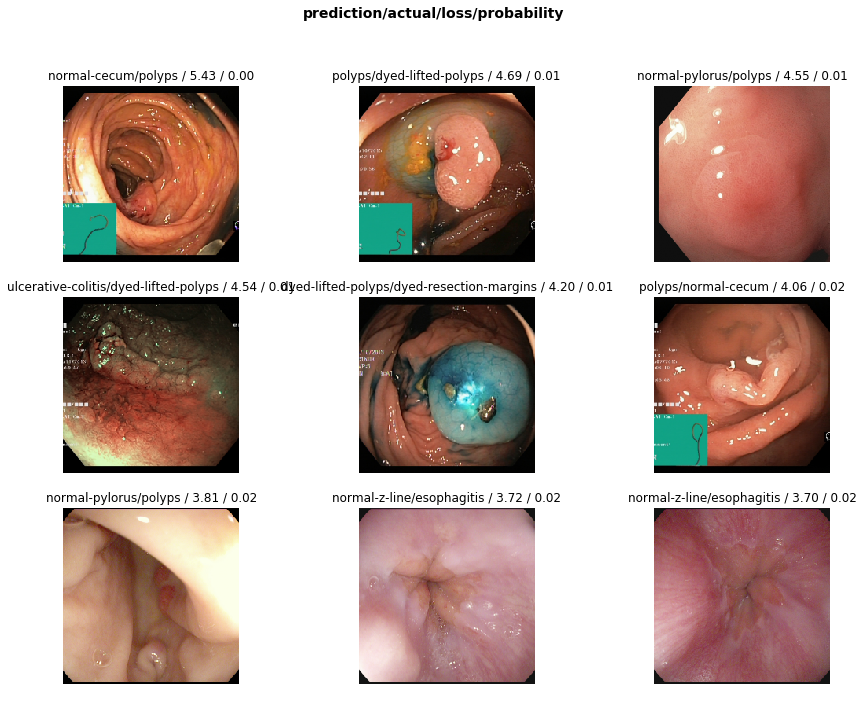

In [20]:
#Lists the top categories
interp.plot_top_losses(9, figsize=(15,11))

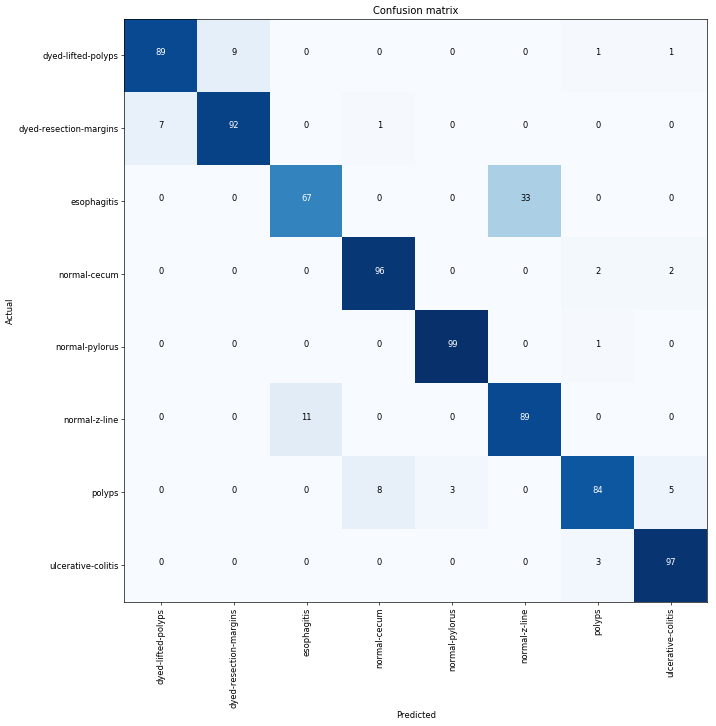

In [21]:
#shows where things went wrong in a confusion matrix
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [22]:
#most confused
interp.most_confused(min_val=2)

[('esophagitis', 'normal-z-line', 33),
 ('normal-z-line', 'esophagitis', 11),
 ('dyed-lifted-polyps', 'dyed-resection-margins', 9),
 ('polyps', 'normal-cecum', 8),
 ('dyed-resection-margins', 'dyed-lifted-polyps', 7),
 ('polyps', 'ulcerative-colitis', 5),
 ('polyps', 'normal-pylorus', 3),
 ('ulcerative-colitis', 'polyps', 3)]

# Training: resnet50
Provides a more accurate (but slower) model for image classification.

In [27]:
# decrease the batch size even further
bs= 24

In [28]:
# II want all the transforms I can get. none of these things really matter with a scope.
# tfms= 

data= ImageDataBunch.from_folder(path, ds_tfms=get_transforms(do_flip=True, flip_vert=True, max_lighting=0.2, max_rotate=359, 
                                                              max_zoom=1.05, max_warp=0.2), size=500, bs=bs//4).normalize(imagenet_stats)

In [29]:
#data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=299, bs=bs//2).normalize(imagenet_stats)

In [30]:
# Create a new learn with 
# data = information provided
# model = is the architecture we are using resnet50
# metrics = what we use to gauge success
learn = create_cnn(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


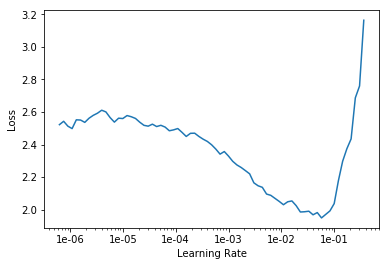

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate
1,0.845905,0.549452,0.215000
2,0.693018,0.418982,0.163750
3,0.673039,0.343801,0.125000
4,0.542122,0.308302,0.125000
5,0.539448,0.258494,0.108750
6,0.413854,0.231946,0.097500
7,0.392512,0.225589,0.093750
8,0.307900,0.224485,0.097500


In [33]:
learn.save('kveset-stage-1-50')

In [34]:
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.349619,0.221442,0.092500
2,0.354610,0.222389,0.088750
3,0.390096,0.225885,0.085000
4,0.385103,0.205051,0.081250
5,0.332995,0.213766,0.087500
6,0.266578,0.205909,0.082500
7,0.298970,0.196694,0.078750
8,0.255576,0.193465,0.078750


In [35]:
learn.save('kveset-stage-1-50')

In [36]:
learn.load('kveset-stage-1-50');

In [37]:
interp = ClassificationInterpretation.from_learner(learn)

In [38]:
interp.most_confused(min_val=2)

[('esophagitis', 'normal-z-line', 28),
 ('normal-z-line', 'esophagitis', 10),
 ('dyed-lifted-polyps', 'dyed-resection-margins', 5),
 ('dyed-resection-margins', 'dyed-lifted-polyps', 4),
 ('polyps', 'normal-cecum', 4)]

## Results

In [39]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

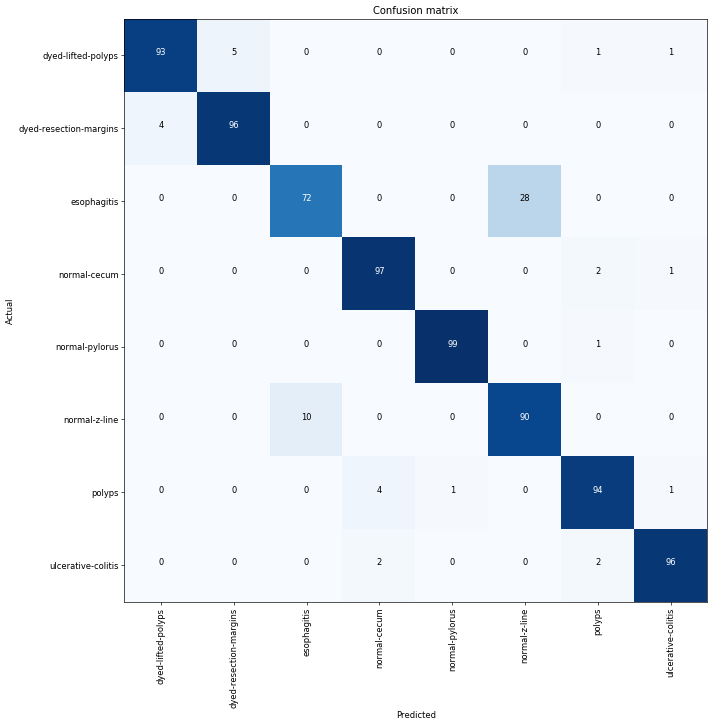

In [40]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

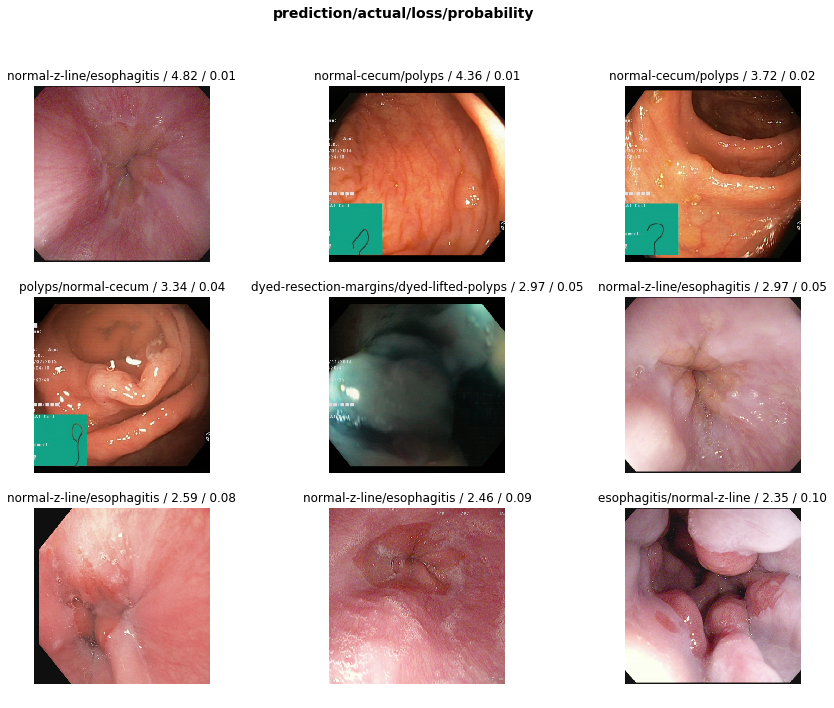

In [41]:
interp.plot_top_losses(9, figsize=(15,11))

## Do more Interations work?

In [42]:
learn.load('kveset-stage-1-50v2');

In [43]:
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.168975,0.184876,0.073750
2,0.178688,0.194821,0.065000
3,0.192794,0.192966,0.073750
4,0.182719,0.200261,0.070000
5,0.197704,0.179641,0.067500
6,0.190719,0.203243,0.083750
7,0.158386,0.192236,0.075000
8,0.168928,0.185466,0.073750


In [44]:
learn.save('kveset-stage-1-50v2')

In [45]:
interp = ClassificationInterpretation.from_learner(learn)

In [46]:
interp.most_confused(min_val=2)

[('esophagitis', 'normal-z-line', 31),
 ('normal-z-line', 'esophagitis', 7),
 ('dyed-resection-margins', 'dyed-lifted-polyps', 5),
 ('ulcerative-colitis', 'polyps', 4),
 ('dyed-lifted-polyps', 'dyed-resection-margins', 3),
 ('polyps', 'normal-cecum', 3)]

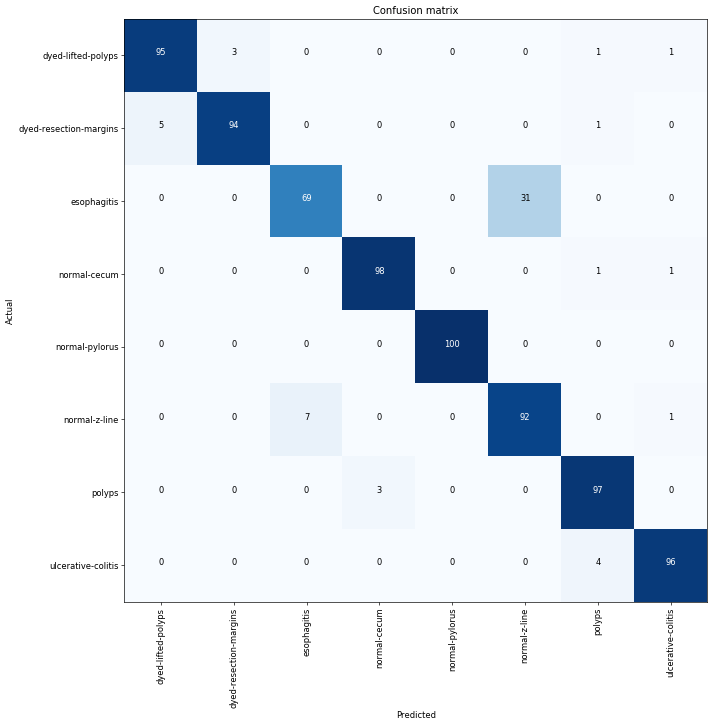

In [47]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Results / Findings

The data seem fairly accurate with us getting down to 91% successful classifcation rate. However, I think some of these items could have multiple classifiers instead of just one. There is a larger dataset that I will be looking at in the Kveset set. Also, I should be considering that there should be mutliple classifications on some of these items.

I used about 10% of the data for validation. The biggest issue was putting them in the correct folders.

### Lessons Learned
Transformations, and lots of them, helped substatially in getting better results. Since the image could literally be in any direction, I allowed for full rotations and changing of colors.

The biggest problem is esophagitis vs a normal z-line. I'm not sure how that would be better classified.